In [58]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [19]:
## hyper parameters:
BATCH_SIZE = 64
EPOCH = 50
LR = 0.001
VAL_SPLIT = 0.2

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using GPU' if device else 'using CPU')

using GPU


In [59]:
samples = 64 #num of sample per batch
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(28),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(3), 
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(28),
        transforms.Grayscale(3),
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

trainset = datasets.FashionMNIST(root='./data', train=True, 
                        download=True, transform=data_transforms['train'])

trainset, valset = random_split(trainset, (50000,10000))

trainloader = DataLoader(trainset, batch_size=samples, shuffle=True, 
                                          num_workers=4)

testset = datasets.FashionMNIST(root='./data', train=False, 
                       download=True,transform=data_transforms['test'])

testloader = DataLoader(testset, batch_size=samples, shuffle=False, 
                                         num_workers=4)

valloader = DataLoader(valset, batch_size=samples, shuffle=False, 
                                         num_workers=4)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


image_datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {'train': trainloader, 'val': valloader, 'test': testloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

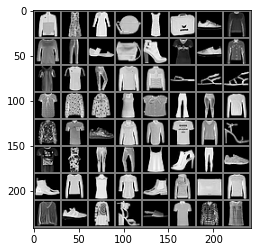

In [61]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [62]:
def build_fine_tune_model():
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    model = model.to(device)
    return model

def build_backbone_model():
    model = torchvision.models.resnet18(pretrained=True)
    #inja parameter haro freeze mikonim:
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    model = model.to(device)
    return model

In [70]:
class MyCNN(nn.Module):
    
    def __init__(self):
        super(MyCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [63]:
def train_model(model, criterion, optimizer, scheduler, val_acc, 
                val_loss, train_acc, train_loss,epoch, 
                num_epochs=25):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
    list = {'train': {'acc': train_acc, 'loss': train_loss}, 
        'val':{'acc': val_acc, 'loss': val_loss}}
    next = epoch
    for epoch in range(next, next+num_epochs):
        print('Epoch : {}/{}'.format(epoch, next + num_epochs - 1))
#         print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
        
            running_loss = 0.0
            running_corrects = 0
        
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
        
                # zero the parameter gradients
                optimizer.zero_grad()
        
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            list[phase]['loss'].append(epoch_loss)
            list[phase]['acc'].append(epoch_acc.item())
        
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
        
    # load best model weights
#     model.load_state_dict(best_model_wts)
    
        
    return model, epoch + 1

In [68]:
model = build_fine_tune_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

epoch = 0
val_acc = []
val_loss = []
train_acc = []
train_loss = []

model, epoch = train_model(model, criterion, optimizer, scheduler, val_acc, val_loss, 
                    train_acc, train_loss, epoch, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4809 Acc: 0.8288
val Loss: 0.3144 Acc: 0.8854

Epoch 1/9
----------
train Loss: 0.2918 Acc: 0.8936
val Loss: 0.2739 Acc: 0.9011

Epoch 2/9
----------
train Loss: 0.2503 Acc: 0.9088
val Loss: 0.2482 Acc: 0.9083

Epoch 3/9
----------
train Loss: 0.2239 Acc: 0.9176
val Loss: 0.2418 Acc: 0.9127

Epoch 4/9
----------
train Loss: 0.2016 Acc: 0.9251
val Loss: 0.2394 Acc: 0.9142

Epoch 5/9
----------
train Loss: 0.1875 Acc: 0.9320
val Loss: 0.2340 Acc: 0.9180

Epoch 6/9
----------
train Loss: 0.1481 Acc: 0.9457
val Loss: 0.2165 Acc: 0.9268

Epoch 7/9
----------
train Loss: 0.1386 Acc: 0.9481
val Loss: 0.2189 Acc: 0.9252

Epoch 8/9
----------
train Loss: 0.1328 Acc: 0.9515
val Loss: 0.2175 Acc: 0.9255

Epoch 9/9
----------
train Loss: 0.1302 Acc: 0.9520
val Loss: 0.2192 Acc: 0.9243

Training complete in 2m 57s
Best val Acc: 0.926800


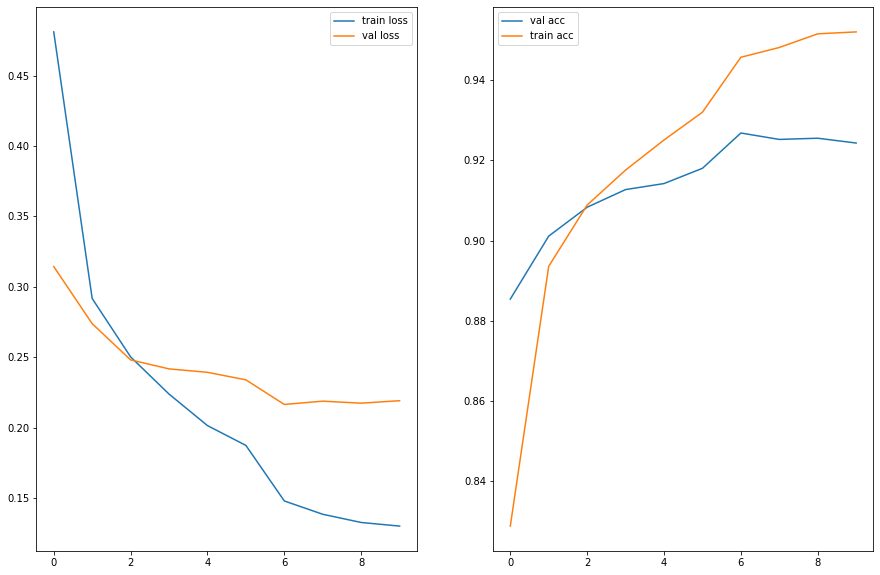

In [69]:
#plots:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(train_loss, label='train loss')
ax1.plot(val_loss, label='val loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(val_acc, label='val acc')
ax2.plot(train_acc, label='train acc')
ax2.legend()

In [ ]:
model = build_backbone_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

epoch = 0
val_acc = []
val_loss = []
train_acc = []
train_loss = []

model, epoch = train_model(model, criterion, optimizer, scheduler, val_acc, val_loss, 
                    train_acc, train_loss, epoch, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.2037 Acc: 0.5989
val Loss: 0.9582 Acc: 0.6814

Epoch 1/9
----------
train Loss: 0.9708 Acc: 0.6712
val Loss: 0.9106 Acc: 0.6943

Epoch 2/9
----------
train Loss: 0.9295 Acc: 0.6813
val Loss: 0.8837 Acc: 0.7000

Epoch 3/9
----------
train Loss: 0.8995 Acc: 0.6888


In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(train_loss, label='train loss')
ax1.plot(val_loss, label='val loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(val_acc, label='val acc')
ax2.plot(train_acc, label='train acc')
ax2.legend()

In [ ]:
model = MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

epoch = 0
val_acc = []
val_loss = []
train_acc = []
train_loss = []

model, epoch = train_model(model, criterion, optimizer, scheduler, val_acc, val_loss, 
                    train_acc, train_loss, epoch, num_epochs=10)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(train_loss, label='train loss')
ax1.plot(val_loss, label='val loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(val_acc, label='val acc')
ax2.plot(train_acc, label='train acc')
ax2.legend()